In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Pretraining

This notebook demonstrates the pre-training step on the MDA-MB-231 Breast Cancer dataset from Horgan, et al. (2021).

In [ ]:
# After running the preprocessing step and saving the preprocessed version of this data, load it accordingly.
# Replace with your own path
!cp '/content/drive/My Drive/repl_normalized_spectra_breastcancer_train_only_1_4.npz' .

Mounted at /content/drive


In [ ]:
import numpy as np

# Replace with your own file
loaded_data = np.load('/content/repl_normalized_spectra_breastcancer_train_only_1_4.npz')
spectra = loaded_data['spectra']
wavelengths = loaded_data['wavelengths']

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')

FONTSIZE_AXIS = 15
FONTSIZE_TITLE=15

In [ ]:
# This may be different for non-colab environments
!pip install tf_keras

!export TF_USE_LEGACY_KERAS=1
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflow as tf #importing tensorflow after setting the environment variable is important

import tensorflow as tf
import tf_keras as keras
print(tf.__version__)
print(keras.__version__)

!pip install tensorflow-addons

2.17.1
2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 39.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import os

# slightly faster improvements, on the first epoch 30 second decrease and a 1-2 second
# decrease in epoch time. Overall saves approx. 5 min of training time

# Allocates two threads for a gpu private which allows more operations to be
# done faster
# os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
!pip install tensorflow-addons==0.16.1
# import tensorflow_addons as tfa

# import tensorflow_addons as tfa  # LAMB optimizer and gaussian_blur_2d function
import numpy as np  # np.random.random
import matplotlib.pyplot as plt  # graphs
import datetime  # tensorboard logs naming

# XLA optimization for faster performance(up to 10-15 minutes total time saved)
# tf.config.optimizer.set_jit(True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0


In [ ]:
# Batch size of dataset
BATCH_SIZE = 512

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import Optional, Tuple, List

# Import tensorflow
import tensorflow as tf

from scipy.ndimage import uniform_filter1d


@dataclass
class AugmentationConfigTensor:
    """
    Configuration for Raman data augmentation parameters.

    Attributes:
        noise_std (float): Standard deviation for Gaussian noise.
        blur_kernel_range (Tuple[int, int]): Range for random average blur kernel size.
        zero_prob (float): Probability of setting a given point to zero.
        scale_range (Tuple[float, float]): Range for random intensity scaling.
        aug_probability (float): Probability of applying augmentation.
        snr_range (Tuple[float, float]): Range of SNR values used for shot noise.
        wavenumber_shift_range (int): Maximum possible shift in the wavenumber axis.
        peak_broadening_factor (float): Factor for random peak broadening.
        region_dropout_prob (float): Probability of randomly dropping a continuous region.
        region_dropout_size (float): Fraction of the spectrum to drop during region dropout.
    """
    noise_std: float = 0.01
    blur_kernel_range: Tuple[int, int] = (2, 5)
    zero_prob: float = 0.02
    scale_range: Tuple[float, float] = (0.9, 1.1)
    aug_probability: float = 1.0

    # Additional parameters for advanced augmentations
    snr_range: Tuple[float, float] = (10, 20)
    wavenumber_shift_range: int = 5
    peak_broadening_factor: float = 0.02
    region_dropout_prob: float = 0.2
    region_dropout_size: float = 0.1


class RamanAugmentorTensor:
    """
    Handles data augmentation for Raman spectra using a configurable set of methods.

    Each augmentation method follows the single responsibility principle:
      - One method for each augmentation transformation.
      - A unified `augment` method that orchestrates the pipeline based on probabilities.
    """

    def __init__(self, config: AugmentationConfigTensor):
        """
        Initialize the RamanAugmentor with a given configuration.

        Args:
            config (AugmentationConfig): Configuration containing augmentation parameters.
        """
        self.config = config
    @tf.function
    def add_gaussian_noise(self, spectrum: tf.Tensor) -> tf.Tensor:
        """
        Add random Gaussian noise to the input spectrum.

        Args:
            spectrum (np.ndarray): 1D array of Raman intensities.

        Returns:
            np.ndarray: Spectrum with added Gaussian noise.
        """
        #print("random_guassian_noise")
        noise = tf.random.normal(shape=tf.shape(spectrum), mean=0.0, stddev=self.config.noise_std, dtype=spectrum.dtype)
        return spectrum + noise
    @tf.function
    def add_shot_noise(self, spectrum: tf.Tensor) -> tf.Tensor:
        """
        Add shot (Poisson) noise to the input spectrum based on a random SNR.

        Args:
            spectrum (np.ndarray): 1D array of Raman intensities.

        Returns:
            np.ndarray: Spectrum with Poisson-based shot noise added.
        """
        #print("random_shot_noise")
        # Shift spectrum to ensure positivity
        min_val = tf.reduce_min(spectrum)
        spectrum_pos = spectrum - min_val + 1e-10

        # Random SNR from the specified range
        snr = tf.random.uniform(shape=[], minval=self.config.snr_range[0], maxval=self.config.snr_range[1], dtype=spectrum.dtype)

        # Compute noise level based on SNR
        signal_power = tf.reduce_mean(tf.square(spectrum_pos))
        noise_power = signal_power / (tf.square(snr))

        # Generate Poisson noise
        poisson_input = spectrum_pos / noise_power
        noise_poisson = tf.random.poisson(shape=tf.shape(poisson_input), lam=poisson_input, dtype=spectrum.dtype)
        noise_scaled = noise_poisson * noise_power

        # Re-center noise around 0
        noise_centered = noise_scaled - tf.reduce_mean(noise_scaled)

        # Restore offset
        return spectrum + noise_centered
    @tf.function
    def average_blur(self, spectrum):
        spectrum = tf.ensure_shape(spectrum, [1000])
        spectrum = tf.expand_dims(tf.expand_dims(spectrum, axis=0), axis=-1)

        # Hardcoded blur kernel range (min=2, max=5)
        kernel_size = np.random.randint(2, 5 + 1)

        blurred = tf.nn.avg_pool1d(
            spectrum,
            ksize=kernel_size,
            strides=1,
            padding='SAME',
            data_format='NWC'
        )

        result = tf.squeeze(blurred)
        return tf.ensure_shape(result, [1000])

    @tf.function
    def random_zero(self, spectrum: tf.Tensor) -> tf.Tensor:
        """
        Randomly set intensities in the spectrum to zero.

        Args:
            spectrum (np.ndarray): 1D array of Raman intensities.

        Returns:
            np.ndarray: Spectrum with some points set to zero.
        """
        #print("random_zero")
        mask = tf.random.uniform(shape=tf.shape(spectrum), minval=0.0, maxval=1.0, dtype=spectrum.dtype) < self.config.zero_prob
        spectrum_copy = tf.where(mask, tf.zeros_like(spectrum), spectrum)
        return spectrum_copy
    @tf.function
    def random_scale(self, spectrum: tf.Tensor) -> tf.Tensor:
        """
        Randomly scale spectrum intensities by a factor in the specified range.

        Args:
            spectrum (np.ndarray): 1D array of Raman intensities.

        Returns:
            np.ndarray: Scaled spectrum.
        """
        #print("random_scale")
        scale = tf.random.uniform(shape=[], minval=self.config.scale_range[0], maxval=self.config.scale_range[1], dtype=spectrum.dtype)
        return spectrum * scale

    @tf.function
    def random_wavenumber_shift(self, spectrum: tf.Tensor) -> tf.Tensor:
        """
        Randomly shift the spectrum along the wavenumber axis.
        This simulates slight peak shifts caused by temperature or calibration differences.

        Args:
            spectrum (np.ndarray): 1D array of Raman intensities.

        Returns:
            np.ndarray: Shifted spectrum.
        """
        #print("random_wavenumber_shift")
        shift = tf.random.uniform(shape=[], minval=-self.config.wavenumber_shift_range, maxval=self.config.wavenumber_shift_range + 1, dtype=tf.int32)
        shifted_spectrum = tf.roll(spectrum, shift=shift, axis=0)
        return shifted_spectrum

    @tf.function
    def random_peak_broadening(self, spectrum: tf.Tensor) -> tf.Tensor:
        """
        Broaden peaks by convolution-like smoothing to simulate instrumental or sample heterogeneity.

        This is a simplified approach that uses a mild smoothing factor;
        you can use more specialized methods (e.g., Voigt broadening) if needed.

        Args:
            spectrum (np.ndarray): 1D array of Raman intensities.

        Returns:
            np.ndarray: Spectrum with artificially broadened peaks.
        """
        #print("random_peak_broadning")
        # Example broadening implemented by repeated uniform filtering
        broadening_factor = self.config.peak_broadening_factor
        # Convert fraction to kernel size
        kernel_size = tf.cast(tf.maximum(1, tf.cast(tf.shape(spectrum)[0] * broadening_factor, dtype=tf.int32)), dtype=tf.int32)

        # Use tf.nn.avg_pool1d for peak broadening.
        # Reshape to [batch, width, channels] for tf.nn.avg_pool1d
        spectrum = tf.expand_dims(tf.expand_dims(spectrum, axis=0), axis=-1)
        broadened_spectrum = tf.nn.avg_pool1d(spectrum, ksize=kernel_size, strides=1, padding='SAME')
        # Reshape back to original shape
        broadened_spectrum = tf.squeeze(tf.squeeze(broadened_spectrum, axis=-1), axis=0)
        return broadened_spectrum

    @tf.function
    def random_region_dropout(self, spectrum: tf.Tensor) -> tf.Tensor:
        """
        Randomly drop a contiguous region of the spectrum to simulate missing or occluded data.

        Args:
            spectrum (np.ndarray): 1D array of Raman intensities.

        Returns:
            np.ndarray: Spectrum with a region set to zero.
        """
        #print("random_region_dropout")
        if tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=spectrum.dtype) > self.config.region_dropout_prob:
            return spectrum

        drop_size = tf.cast(tf.shape(spectrum)[0] * self.config.region_dropout_size, dtype=tf.int32)
        if drop_size <= 0:
            return spectrum

        start_index = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(spectrum)[0] - drop_size, dtype=tf.int32)
        spectrum_copy = tf.tensor_scatter_nd_update(spectrum, tf.expand_dims(tf.range(start_index, start_index + drop_size), axis=-1), tf.zeros(shape=[drop_size], dtype=spectrum.dtype))
        return spectrum_copy

    @tf.function
    def augment(self, spectrum: tf.Tensor) -> tf.Tensor:
        """
        Apply a combination of random augmentations based on the probability specified
        in the AugmentationConfig. Not all augmentations are applied each time.

        Args:
            spectrum (np.ndarray): 1D array of Raman intensities.

        Returns:
            np.ndarray: Augmented spectrum.
        """
        # If we decide not to apply augmentation, return original
        # Use tf.cond for conditional execution based on aug_probability
        spectrum = tf.cond(
            tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=spectrum.dtype) < self.config.aug_probability,
            lambda: self._augment_impl(spectrum),
            lambda: spectrum
        )
        return spectrum

    @tf.function
    def _augment_impl(self, spectrum: tf.Tensor) -> tf.Tensor:
        """Internal implementation of the augmentation logic."""
        # # Step 1: Noise or blur
        randval = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=spectrum.dtype)
        spectrum = tf.cond(randval < 0.50, lambda: self.add_gaussian_noise(spectrum), lambda: spectrum)
        spectrum = tf.cond(randval < 0.75 and randval >= 0.25, lambda: self.average_blur(spectrum), lambda: spectrum)
        #spectrum = tf.cond(randval < 0.75 and randval >= 0.50, lambda: self.add_shot_noise(spectrum), lambda: spectrum)

        # # Step 2: Additional advanced augmentations (each has an independent probability)
        randval = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=spectrum.dtype)
        spectrum = tf.cond(randval < 0.25, lambda: self.random_wavenumber_shift(spectrum), lambda: spectrum)
        # spectrum = tf.cond(randval < 0.5 and randval >= 0.25, lambda: self.random_peak_broadening(spectrum), lambda: spectrum)
        # spectrum = tf.cond(randval < 0.75 and randval >= 0.5, lambda: self.random_region_dropout(spectrum), lambda: spectrum)

        # Step 3: Random zero and scale
        randval = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=spectrum.dtype)
        spectrum = tf.cond(randval < 0.5, lambda: self.random_zero(spectrum), lambda: spectrum)
        spectrum = tf.cond(randval < 0.75 and randval >= 0.5, lambda: self.random_scale(spectrum), lambda: spectrum)

        return spectrum
    @tf.function
    def __call__(self, x : tf.Tensor) -> tf.Tensor:
      return self.augment(x)

# TODO change misspelling
ramon_augmentor = RamanAugmentorTensor(AugmentationConfigTensor())

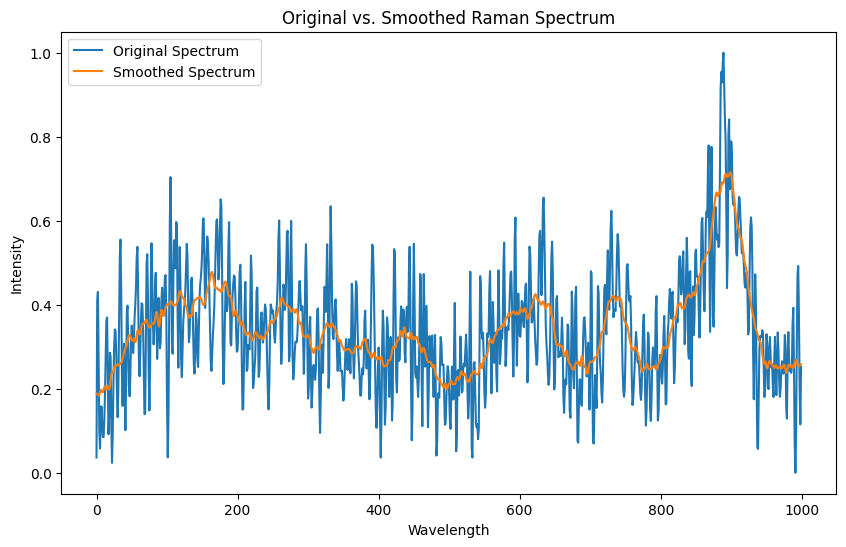

In [ ]:
# prompt: smooth spectra[1]

import numpy as np
from scipy.ndimage import uniform_filter1d

def smooth_spectra(spectra, window_length=11):
  """
  Smooths Raman spectra using a uniform filter.

  Args:
    spectra: A NumPy array of shape (num_spectra, num_wavelengths) representing the Raman spectra.
    window_length: The size of the smoothing window.

  Returns:
    A NumPy array of the same shape as spectra, with smoothed spectra.
  """
  smoothed_spectra = np.zeros_like(spectra, dtype=float)
  for i in range(spectra.shape[0]):
    smoothed_spectra[i, :] = uniform_filter1d(spectra[i, :], size=window_length)
  return smoothed_spectra

# Example usage (assuming 'spectra' is your data):
# Assuming spectra is loaded as in your provided code.
# Smooth the spectra
smoothed_spectra = smooth_spectra(spectra, window_length=30)
plt.figure(figsize=(10, 6))
plt.plot(spectra[0], label='Original Spectrum')
plt.plot(smoothed_spectra[0], label='Smoothed Spectrum')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Original vs. Smoothed Raman Spectrum')
plt.legend()
plt.show()

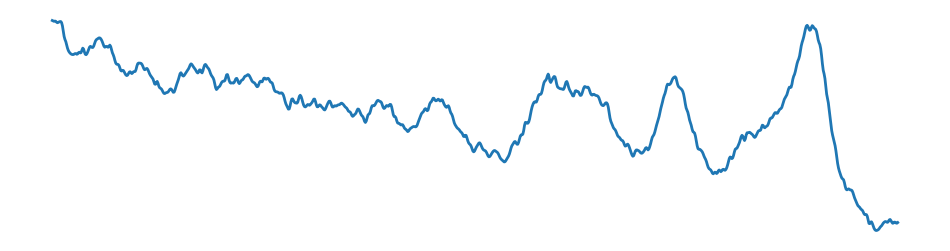

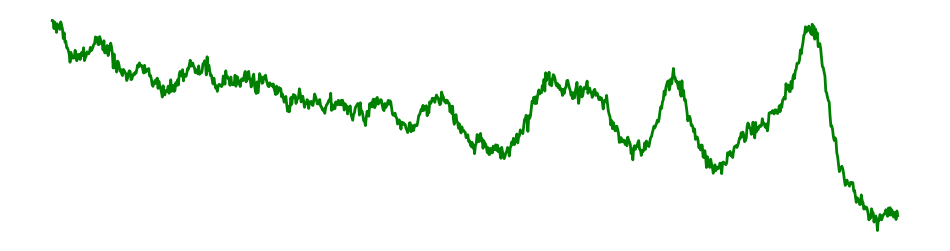

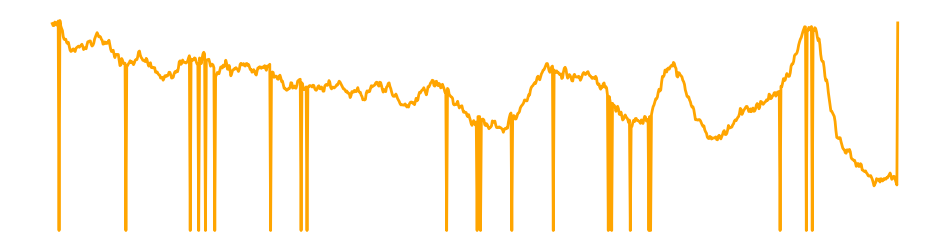

In [ ]:
plt.figure(figsize=(12, 3))
# remove all axes
plt.axis('off')
plt.plot(smoothed_spectra[1], linewidth=2)
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(ramon_augmentor(smoothed_spectra[1]), 'g', linewidth=2)
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(ramon_augmentor(smoothed_spectra[1]), 'orange', linewidth=2)
plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

class RamonAugmentorModel:
    def __init__(self, batch_size: int = 32, seed: int = 1024):
        super().__init__()
        self.options = tf.data.Options()
        self.options.threading.max_intra_op_parallelism = 1
        self.seed = seed
        self.batch_size = batch_size
        self.ramon_augmentor = RamanAugmentorTensor(AugmentationConfigTensor())

    @tf.function
    def augment_single(self, x):
        """Augment a single spectrum"""
        # Track input shape
        #tf.print("Input shape to augment_single:", tf.shape(x))

        # Ensure input is 1D
        x = tf.ensure_shape(x, [1000])

        # Apply augmentation
        augmented = self.ramon_augmentor(x)

        # Track output shape
        #tf.print("Output shape from augmentation:", tf.shape(augmented))

        # Ensure output shape is correct
        augmented = tf.ensure_shape(augmented, [1000])
        return augmented

    def augmented_version(self, ds: np.ndarray) -> tf.data.Dataset:
        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices(ds)

        # Debug shapes after dataset creation
        first_element = next(iter(dataset))
        #tf.print("Shape after dataset creation:", tf.shape(first_element))

        # Apply augmentation pipeline
        augmented_dataset = (
            dataset
            .map(self.augment_single)
            .batch(self.batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

        return augmented_dataset

    def __call__(self, ds: np.ndarray) -> tf.data.Dataset:
        if len(ds.shape) != 2 or ds.shape[1] != 1000:
            raise ValueError(f"Expected input shape (N, 1000), got {ds.shape}")

        # Create augmented versions
        a1 = self.augmented_version(ds)
        a2 = self.augmented_version(ds)

        # Return zipped dataset
        return tf.data.Dataset.zip((a1, a2)).with_options(self.options)

# Test the implementation
augmentor = RamonAugmentorModel(batch_size=BATCH_SIZE)

print(spectra.shape)
augment_versions = augmentor(spectra) # out of domain data set

(159618, 1000)


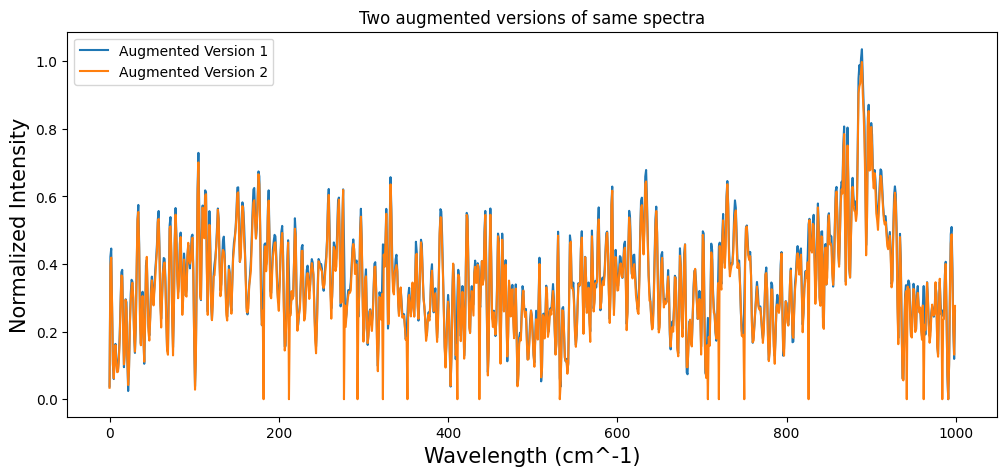

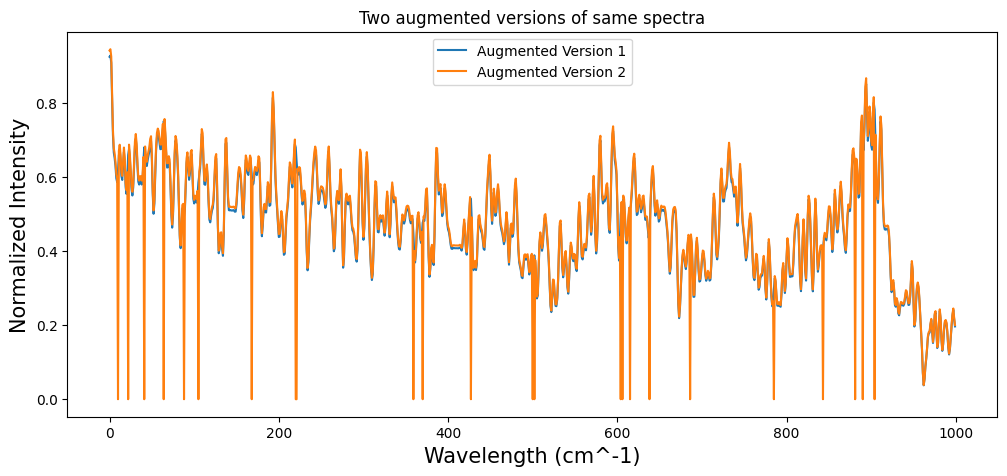

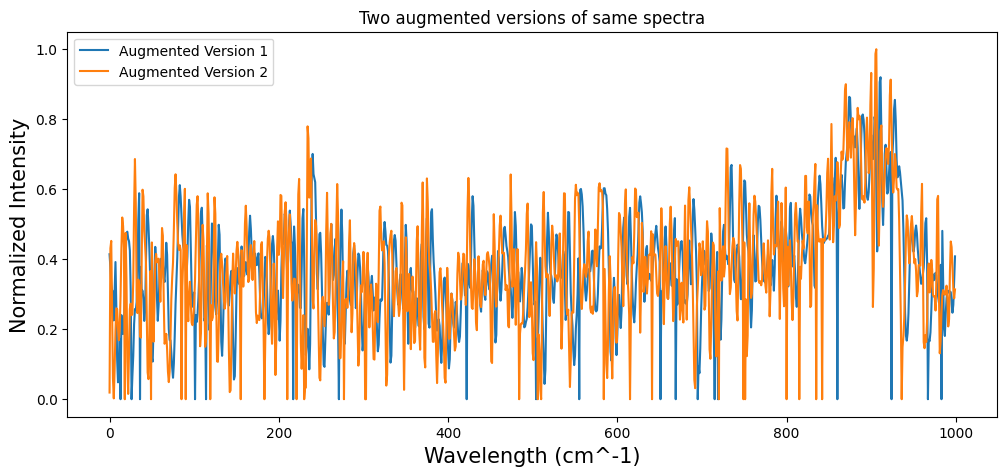

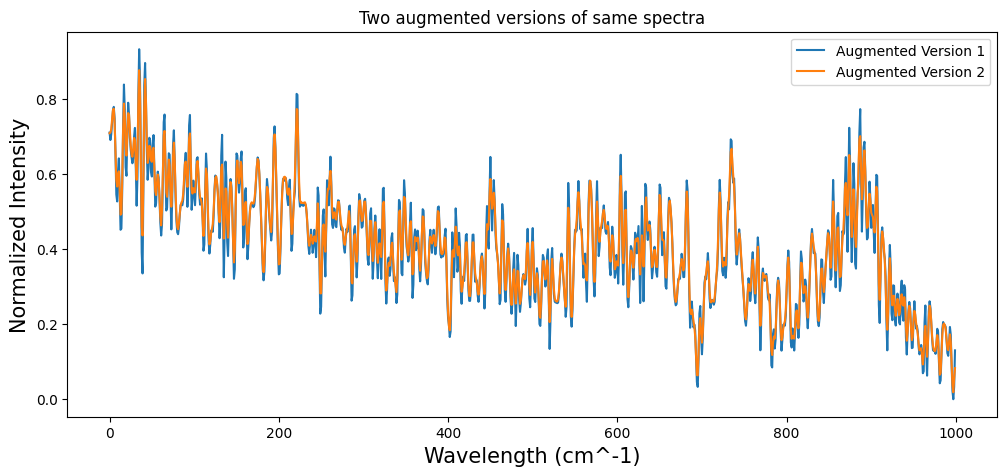

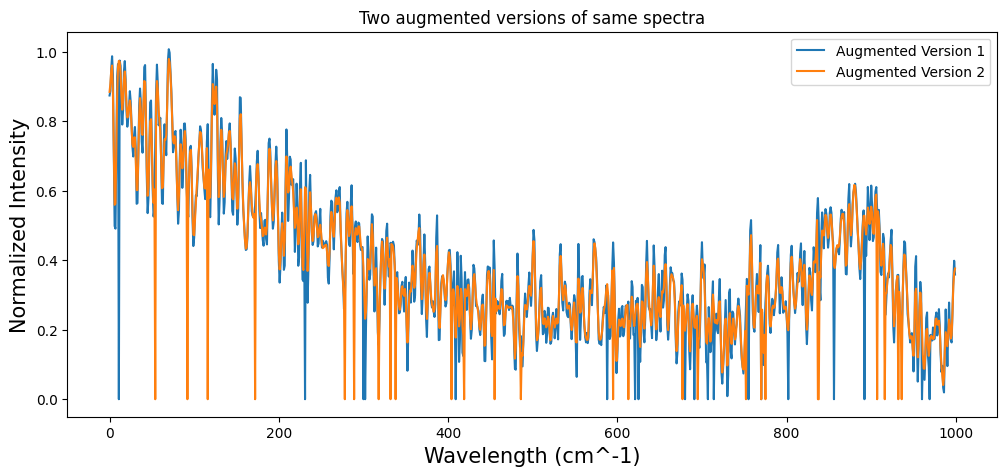

In [ ]:
sample_augment_versions = iter(augment_versions)
#print(next(sample_augment_versions))

def plot_values(batch: tuple):
    # fig, axs = plt.subplots(2, 1)
    # fig1, axs1 = plt.subplots(3, 1)

    # Adapt for signal data
    # fig.suptitle("Augmentation 1")
    # fig1.suptitle("Augmentation 2")

    a1, a2 = batch

    for i in range(5):
      plt.figure(figsize=(12, 5))
      plt.plot(a1[i], label="Augmented Version 1")
      plt.plot(a2[i], label="Augmented Version 2")
      plt.title("Two augmented versions of same spectra")
      plt.xlabel('Wavelength (cm^-1)', fontsize=FONTSIZE_AXIS)
      plt.ylabel('Normalized Intensity', fontsize=FONTSIZE_AXIS)
      plt.legend()
      plt.show()

# add augmentations like random baseline
plot_values(next(sample_augment_versions))

In [ ]:

class BarlowLoss(keras.losses.Loss):
    """BarlowLoss class.

    BarlowLoss class. Creates a loss function based on the cross-correlation
    matrix.

    Attributes:
        batch_size: the batch size of the dataset
        lambda_amt: the value for lambda(used in cross_corr_matrix_loss)

    Methods:
        __init__: gets instance variables
        call: gets the loss based on the cross-correlation matrix
          make_diag_zeros: Used in calculating off-diagonal section
          of loss function; makes diagonals zeros.
        cross_corr_matrix_loss: creates loss based on cross correlation
          matrix.
    """

    def __init__(self, batch_size: int):
        """__init__ method.

        Gets the instance variables

        Arguments:
            batch_size: An integer value representing the batch size of the
              dataset. Used for cross correlation matrix calculation.
        """

        super().__init__()
        self.lambda_amt = 5e-3
        self.batch_size = batch_size

    def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
        """get_off_diag method.

        Makes the diagonals of the cross correlation matrix zeros.
        This is used in the off-diagonal portion of the loss function,
        where we take the squares of the off-diagonal values and sum them.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        zero_diag = tf.zeros(c.shape[-1])
        return tf.linalg.set_diag(c, zero_diag)

    def cross_corr_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix_loss method.

        Gets the loss based on the cross correlation matrix.
        We want the diagonals to be 1's and everything else to be
        zeros to show that the two augmented images are similar.

        Loss function procedure:
        take the diagonal of the cross-correlation matrix, subtract by 1,
        and square that value so no negatives.

        Take the off-diagonal of the cc-matrix(see get_off_diag()),
        square those values to get rid of negatives and increase the value,
        and multiply it by a lambda to weight it such that it is of equal
        value to the optimizer as the diagonal(there are more values off-diag
        then on-diag)

        Take the sum of the first and second parts and then sum them together.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        # subtracts diagonals by one and squares them(first part)
        c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)

        # takes off diagonal, squares it, multiplies with lambda(second part)
        off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt

        # sum first and second parts together
        loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)

        return loss

    def normalize(self, output: tf.Tensor) -> tf.Tensor:
        """normalize method.

        Normalizes the model prediction.

        Arguments:
            output: the model prediction.

        Returns:
            Returns a normalized version of the model prediction.
        """

        return (output - tf.reduce_mean(output, axis=0)) / tf.math.reduce_std(
            output, axis=0
        )

    def cross_corr_matrix(self, z_a_norm: tf.Tensor, z_b_norm: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix method.

        Creates a cross correlation matrix from the predictions.
        It transposes the first prediction and multiplies this with
        the second, creating a matrix with shape (n_dense_units, n_dense_units).
        See build_twin() for more info. Then it divides this with the
        batch size.

        Arguments:
            z_a_norm: A normalized version of the first prediction.
            z_b_norm: A normalized version of the second prediction.

        Returns:
            Returns a cross correlation matrix.
        """
        return (tf.transpose(z_a_norm) @ z_b_norm) / self.batch_size

    def call(self, z_a: tf.Tensor, z_b: tf.Tensor) -> tf.Tensor:
        """call method.

        Makes the cross-correlation loss. Uses the CreateCrossCorr
        class to make the cross corr matrix, then finds the loss and
        returns it(see cross_corr_matrix_loss()).

        Arguments:
            z_a: The prediction of the first set of augmented data.
            z_b: the prediction of the second set of augmented data.

        Returns:
            Returns a (rank-0) tf.Tensor that represents the loss.
        """

        z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
        c = self.cross_corr_matrix(z_a_norm, z_b_norm)
        loss = self.cross_corr_matrix_loss(c)
        return loss

In [ ]:
class ResNet34Old:
    """Resnet34 class.
        Responsible for the Resnet 34 architecture.
    Modified from
    https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
        View their website for more information.
    """
    def __init__(self):
        self.model = None

    def identity_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv1D(filter, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=2)(x)  # CHANGED: axis=3 -> axis=2 for 1D
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv1D(filter, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=2)(x)  # CHANGED: axis=3 -> axis=2 for 1D
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def convolutional_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv1D(filter, 3, padding="same", strides=2)(x)
        x = tf.keras.layers.BatchNormalization(axis=2)(x)  # CHANGED: axis=3 -> axis=2 for 1D
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv1D(filter, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=2)(x)  # CHANGED: axis=3 -> axis=2 for 1D
        # Processing Residue with conv(1,1)
        x_skip = tf.keras.layers.Conv1D(filter, 1, strides=2)(x_skip)
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    # CHANGED: Default shape to include channel dimension
    def __call__(self, shape=(1000, 1)):
        # Step 1 (Setup Input Layer)
        x_input = tf.keras.layers.Input(shape)
        x = tf.keras.layers.ZeroPadding1D(3)(x_input)
        # Step 2 (Initial Conv layer along with maxPool)
        x = tf.keras.layers.Conv1D(64, kernel_size=7, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding="same")(x)
        # Define size of sub-blocks and initial filter size
        block_layers = [3, 4, 6, 3]
        filter_size = 64
        # Step 3 Add the Resnet Blocks
        for i in range(4):
            if i == 0:
                for j in range(block_layers[i]):
                    x = self.identity_block(x, filter_size)
            else:
                filter_size = filter_size * 2
                x = self.convolutional_block(x, filter_size)
                for j in range(block_layers[i] - 1):
                    x = self.identity_block(x, filter_size)
        # Step 4 End Dense Network
        x = tf.keras.layers.AveragePooling1D(2, padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
        self.model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
        return self.model

    @property
    def layers(self):
        if self.model is None:
            raise AttributeError("Model hasn't been built yet. Call the model first.")
        return self.model.layers

In [ ]:
def build_twin() -> keras.Model:
    """build_twin method.

    Builds a barlow twins model consisting of an encoder(resnet-34)
    and a projector, which generates embeddings for the images

    Returns:
        returns a barlow twins model
    """

    # number of dense neurons in the projector
    n_dense_neurons = 2048

    # encoder network
    resnet = ResNet34Old()()
    # resnet = create_fresh_cnn_raman()
    last_layer = resnet.layers[-1].output

    # intermediate layers of the projector network
    n_layers = 2
    for i in range(n_layers):
        dense = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{i}")
        if i == 0:
            x = dense(last_layer)
        else:
            x = dense(x)
        x = tf.keras.layers.BatchNormalization(name=f"projector_bn_{i}")(x)
        x = tf.keras.layers.ReLU(name=f"projector_relu_{i}")(x)

    x = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{n_layers}")(x)

    model = keras.Model(resnet.input, x)
    return model

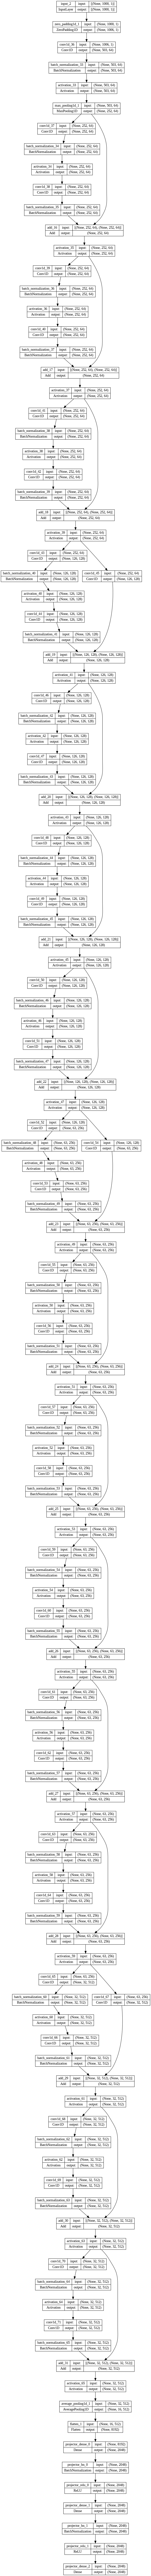

In [ ]:
test_model = build_twin()
# plot model
tf.keras.utils.plot_model(test_model, show_shapes=True)

In [ ]:
class BarlowModel(keras.Model):
    """BarlowModel class.

    BarlowModel class. Responsible for making predictions and handling
    gradient descent with the optimizer.

    Attributes:
        model: the barlow model architecture.
        loss_tracker: the loss metric.

    Methods:
        train_step: one train step; do model predictions, loss, and
            optimizer step.
        metrics: Returns metrics.
    """

    def __init__(self):
        super().__init__()
        self.model = build_twin()
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, batch: tf.Tensor) -> tf.Tensor:
        """train_step method.

        Do one train step. Make model predictions, find loss, pass loss to
        optimizer, and make optimizer apply gradients.

        Arguments:
            batch: one batch of data to be given to the loss function.

        Returns:
            Returns a dictionary with the loss metric.
        """

        # get the two augmentations from the batch
        y_a, y_b = batch

        with tf.GradientTape() as tape:
            # get two versions of predictions
            z_a, z_b = self.model(y_a, training=True), self.model(y_b, training=True)
            loss = self.loss(z_a, z_b)

        grads_model = tape.gradient(loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads_model, self.model.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

In [ ]:
bm = BarlowModel()
optimizer = tf.keras.optimizers.AdamW()
loss = BarlowLoss(BATCH_SIZE)
bm.compile(optimizer=optimizer, loss=loss)

Epoch 1/200
312/312 [==============================] - 96s 196ms/step - loss: 290.0826
Epoch 2/200
312/312 [==============================] - 59s 190ms/step - loss: 61.3258
Epoch 3/200
312/312 [==============================] - 59s 190ms/step - loss: 53.3132
Epoch 4/200
312/312 [==============================] - 59s 190ms/step - loss: 49.9352
Epoch 5/200
312/312 [==============================] - 59s 190ms/step - loss: 47.8826
Epoch 6/200
312/312 [==============================] - 59s 190ms/step - loss: 46.4788
Epoch 7/200
312/312 [==============================] - 59s 190ms/step - loss: 45.4668
Epoch 8/200
312/312 [==============================] - 59s 190ms/step - loss: 44.6625
Epoch 9/200
312/312 [==============================] - 59s 190ms/step - loss: 44.0484
Epoch 10/200
312/312 [==============================] - 60s 190ms/step - loss: 43.5717
Epoch 11/200
312/312 [==============================] - 59s 190ms/step - loss: 43.1759
Epoch 12/200
312/312 [=============================

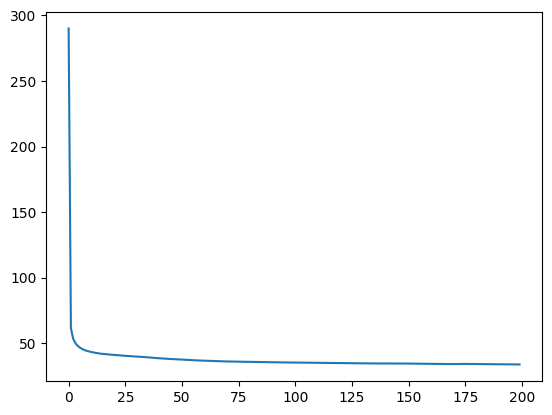

In [ ]:
# Expected training time: 1 hours 30 min

history = bm.fit(augment_versions, epochs=200)
plt.plot(history.history["loss"])
plt.show()

In [ ]:
# Replace with your own file-paths
bm.model.save_weights("repl_breastcancer_pretraining_1_4")
bm.model.save("repl_breastcancer_pretraining_1_4")
bm.model.save('/content/drive/MyDrive/repl_breastcancer_pretraining_1_4', save_format="h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
